In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms

In [2]:
# Device configuration (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters


In [4]:
batch_size = 64
learning_rate = 0.001
num_epochs = 15

# MNIST dataset


In [5]:
transform = transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST(root='./root',
                                           train=True,
                                           transform=transform,
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./root',
                                           train=False,
                                           transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.07MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.50MB/s]


# Simple Feedforward Neural Network

In [6]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)  # flatten
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop


In [7]:
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/15], Loss: 0.3944
Epoch [2/15], Loss: 0.0836
Epoch [3/15], Loss: 0.0482
Epoch [4/15], Loss: 0.0218
Epoch [5/15], Loss: 0.0047
Epoch [6/15], Loss: 0.0256
Epoch [7/15], Loss: 0.0109
Epoch [8/15], Loss: 0.0149
Epoch [9/15], Loss: 0.0026
Epoch [10/15], Loss: 0.0079
Epoch [11/15], Loss: 0.0004
Epoch [12/15], Loss: 0.0078
Epoch [13/15], Loss: 0.0004
Epoch [14/15], Loss: 0.0001
Epoch [15/15], Loss: 0.0025


# Testing loop


In [8]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 97.79%


# Test

Please upload an image of a single handwritten digit.


Saving 1755704726568.png to 1755704726568.png

--- Prediction ---


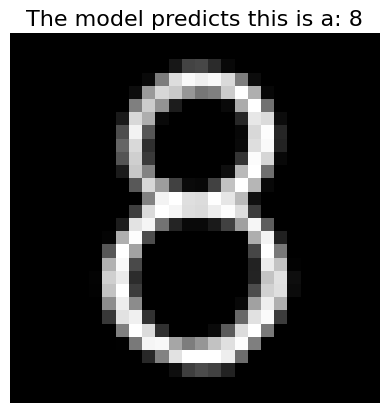

In [11]:
from google.colab import files
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import io

# --- Helper Function to Preprocess the Image ---
def preprocess_image(image_data):
    """
    Prepares the uploaded image to be compatible with the MNIST model.
    - Converts to grayscale
    - Inverts colors (model expects white digit on black background)
    - Resizes to 28x28 pixels
    - Converts to a PyTorch tensor and adds batch dimension
    """
    # Open image and convert to grayscale ('L' mode)
    image = Image.open(io.BytesIO(image_data)).convert('L')

    # MNIST digits are white on a black background. If your image is
    # black on a white background, we need to invert it.
    image = ImageOps.invert(image)

    # Resize to 28x28, the size the model was trained on
    image = image.resize((28, 28))

    # Apply the same ToTensor transformation
    transform = transforms.ToTensor()
    # Add an extra dimension for the batch and send to the correct device
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Return the processed tensor and the image for display
    return image_tensor, image


# --- Main Prediction Logic ---

# 1. Display an upload button
print("Please upload an image of a single handwritten digit.")
uploaded = files.upload()

# Check if a file was uploaded
if len(uploaded) == 0:
    print("No file was uploaded.")
else:
    # Get the first uploaded file's data
    filename = next(iter(uploaded))
    img_data = uploaded[filename]

    # 2. Preprocess the image for the model
    image_tensor, display_image = preprocess_image(img_data)

    # 3. Make a prediction
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad(): # Turn off gradients for inference
        output = model(image_tensor)
        # Get the class with the highest score
        _, predicted = torch.max(output.data, 1)
        prediction = predicted.item()

    # 4. Display the image and the prediction
    print("\n--- Prediction ---")
    plt.imshow(display_image, cmap='gray')
    plt.title(f"The model predicts this is a: {prediction}", fontsize=16)
    plt.axis('off')
    plt.show()

